In [1]:
import datetime
import glob
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
from tqdm import tqdm

import utils

In [2]:
path = 'df_norm_*.csv'

all_files = glob.glob(path)

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0,parse_dates=['time'])
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df = df.set_index('time')
df = df.interpolate(method='linear')
df.to_csv('merged_df_norm.csv')

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


In [3]:
df = pd.read_csv('merged_df_norm.csv',parse_dates=['time'])
time = df['time']
df = df.drop('time',axis=1)

In [4]:
(train_df,val_df,test_df), num_features = utils.train_test_val_split(df)

In [5]:
input_width = 72
label_width = 72
shift = label_width 

In [6]:
w1 = utils.WindowGenerator(input_width, label_width, shift,train_df, val_df, test_df, label_columns=['speed'])
w1

Total window size: 144
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label indices: [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label column name(s): ['speed']

In [7]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 144, 5)
Inputs shape: (3, 72, 5)
labels shape: (3, 72, 1)


In [8]:
w1.make_dataset(w1.train_df)

<MapDataset shapes: ((None, 72, 5), (None, 72, 1)), types: (tf.float32, tf.float32)>

In [9]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 72, 5)
Labels shape (batch, time, features): (32, 72, 1)


In [10]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [11]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', linear(w1.example[0]).shape)

Input shape: (32, 72, 5)
Output shape: (32, 72, 1)


In [12]:
val_performance = {}
performance = {}

In [13]:
history = utils.compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
9050/9050 [==============================] - 40s 4ms/step - loss: 0.6434 - mean_absolute_error: 0.6498 - val_loss: 0.6959 - val_mean_absolute_error: 0.6625
Epoch 2/20
9050/9050 [==============================] - 39s 4ms/step - loss: 0.5651 - mean_absolute_error: 0.6114 - val_loss: 0.6960 - val_mean_absolute_error: 0.6623
Epoch 3/20
9050/9050 [==============================] - 42s 5ms/step - loss: 0.5651 - mean_absolute_error: 0.6114 - val_loss: 0.6957 - val_mean_absolute_error: 0.6621
Epoch 4/20
9050/9050 [==============================] - 46s 5ms/step - loss: 0.5651 - mean_absolute_error: 0.6114 - val_loss: 0.6963 - val_mean_absolute_error: 0.6629
Epoch 5/20
9050/9050 [==============================] - 40s 4ms/step - loss: 0.5651 - mean_absolute_error: 0.6114 - val_loss: 0.6956 - val_mean_absolute_error: 0.6620
Epoch 6/20
9050/9050 [==============================] - 39s 4ms/step - loss: 0.5651 - mean_absolute_error: 0.6114 - val_loss: 0.6962 - val_mean_absolute_error: 0.662

In [14]:
performance['Linear']

[0.6312071084976196, 0.6292334198951721]

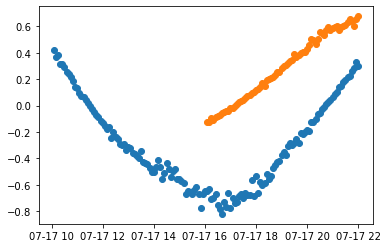

In [202]:
# plt.plot()
ind_0 = np.random.randint(0,len(df)-1)
width = 72

prediction = linear.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+2*width],df[ind_0:ind_0+2*width]['speed'].values)

plt.scatter(time[ind_0+width:ind_0+2*width],prediction)

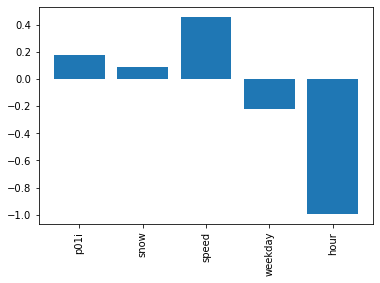

In [16]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [17]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = utils.compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

Epoch 1/20
9050/9050 [==============================] - 93s 10ms/step - loss: 0.2786 - mean_absolute_error: 0.3672 - val_loss: 0.4476 - val_mean_absolute_error: 0.4923
Epoch 2/20
9050/9050 [==============================] - 82s 9ms/step - loss: 0.2544 - mean_absolute_error: 0.3407 - val_loss: 0.4469 - val_mean_absolute_error: 0.4897
Epoch 3/20
9050/9050 [==============================] - 86s 10ms/step - loss: 0.2499 - mean_absolute_error: 0.3346 - val_loss: 0.4417 - val_mean_absolute_error: 0.4783
Epoch 4/20
9050/9050 [==============================] - 95s 11ms/step - loss: 0.2471 - mean_absolute_error: 0.3312 - val_loss: 0.4434 - val_mean_absolute_error: 0.4880
Epoch 5/20
9050/9050 [==============================] - 90s 10ms/step - loss: 0.2455 - mean_absolute_error: 0.3293 - val_loss: 0.4408 - val_mean_absolute_error: 0.4767
Epoch 6/20
9050/9050 [==============================] - 79s 9ms/step - loss: 0.2440 - mean_absolute_error: 0.3277 - val_loss: 0.4419 - val_mean_absolute_error: 0

In [247]:
ind = time[(time>pd.to_datetime('2018-11-16')) & (time<pd.to_datetime('2018-11-17'))].index[0]

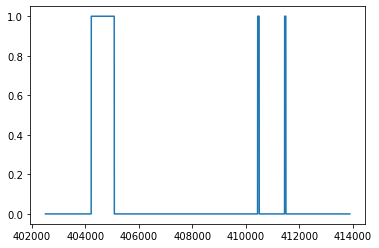

In [248]:
df.loc[ind:]['snow'].plot()

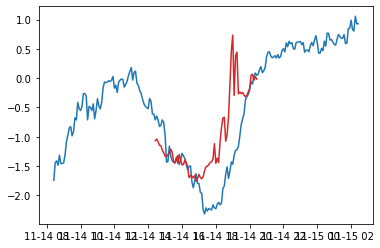

In [257]:
test_case = w1.test_df
inds = test_case[(test_case['p01i']>1) & (test_case['weekday']>0)].index
ind_0 = np.random.randint(0,len(inds)-1)
ind_0 = inds[ind_0]
ind_0 = 401937+100

plt.plot(time.loc[ind_0:ind_0+3*width],df.loc[ind_0:ind_0+3*width]['speed'].values)

df_prec = df.loc[ind_0:ind_0+width].copy()
 
prediction = dense.predict(df_prec)

plt.plot(time.loc[ind_0+width:ind_0+2*width],prediction,label='heavy snow',c='tab:red')

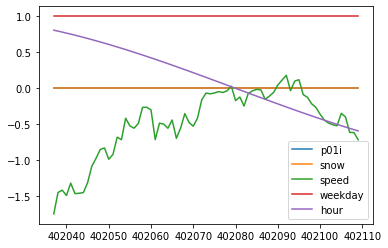

In [252]:
df_prec.plot()

In [254]:
year = '2018'
month1 = 'november'
month2 = 'november'
day1 = '16'
day2 = '17'

baseurl='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?'

request = f'station=NYC\
&data=tmpf&data=dwpf&data=p01i&data=wxcodes\
&year1={year}&month1={month1}&day1={day1}&year2={year}&month2={month2}&day2={day2}&tz=Etc%2FUTC\
&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'

df_weather = pd.read_csv(f'{baseurl}{request}',na_values=['M'])

HTTPError: HTTP Error 500: Internal Server Error

In [255]:
year = '2018'

baseurl='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?'

request = f'station=NYC\
&data=tmpf&data=dwpf&data=p01i&data=wxcodes\
&year1={year}&month1=1&day1=1&year2={year}&month2=12&day2=31&tz=Etc%2FUTC\
&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'

df_weather = pd.read_csv(f'{baseurl}{request}',na_values=['M'])